# Analysis of UK Traffic Accidents and Predicting the Accident Severity
## Tommaso Cortecchia       mat. 0001054600

## Aim of the work
This work is meant to illustrate some features of Spark and Mllib. We are applying it to a classification task on real world data to classify the severity of accidents given the circumstantial conditions.

## Context
The UK government amassed traffic data from 2000 and 2016, recording over 1.6 million accidents in the process and making this one of the most comprehensive traffic data sets out there. It's a huge picture of a country undergoing change. 

## Data ([Link](https://www.kaggle.com/datasets/daveianhickey/2000-16-traffic-flow-england-scotland-wales))
Accidents data is split across three CSV files: accidents_2005_to_2007.csv, accidents_2009_to_2011.csv, and accidents_2012_to_2014.csv. These three files together constitute 1.6 million traffic accidents. The total time period is 2005 through 2014, but 2008 is missing. We will only be using data from 2012 to 2014 (approx. 500k rows).

## Task 
Each accident is labeled with an integer from 1 to 3 representing the accident severity. Our goal is to use the information about the accident to be able to predict its severity. Ideally, this information can then be used by the law enforcement for looking into this and be prepared for the future. We can also have more emergency medical services available for those situations.

## Models
We will be employing three different machine learning models: a decision tree, a random forest, and a logistic regressor. 
We will then compare them and see who's performing better.

## Preliminary steps

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import seaborn as sns 
from itertools import chain 

from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
! hdfs dfs -ls UK-traffic-accidents

Found 7 items
-rw-r--r--   1 ubuntu supergroup    5943100 2023-02-08 09:39 UK-traffic-accidents/Areas.shp
-rw-r--r--   1 ubuntu supergroup  157454130 2023-02-08 09:39 UK-traffic-accidents/Local_Authority_Districts_Dec_2016.geojson
-rw-r--r--   1 ubuntu supergroup       7556 2023-02-08 09:39 UK-traffic-accidents/accident_coords_update.ipynb
-rw-r--r--   1 ubuntu supergroup  163582978 2023-02-08 09:38 UK-traffic-accidents/accidents_2005_to_2007.csv
-rw-r--r--   1 ubuntu supergroup  135319662 2023-02-08 09:39 UK-traffic-accidents/accidents_2009_to_2011.csv
-rw-r--r--   1 ubuntu supergroup  133627887 2023-02-08 09:39 UK-traffic-accidents/accidents_2012_to_2014.csv
-rw-r--r--   1 ubuntu supergroup   55504514 2023-02-08 09:39 UK-traffic-accidents/ukTrafficAADF.csv


In [3]:
spark = SparkSession.builder.appName("Road Traffic Crash Clustering").getOrCreate()
sc = spark.sparkContext

23/02/13 21:45:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Load Dataset and preprocess data

In [4]:
df = spark.read.format('csv').option('header','True').option("inferSchema", "True")\
        .load('UK-traffic-accidents/accidents_2012_to_2014.csv')

In [5]:
df.show(5)

23/02/13 21:46:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+---------------------+----------------------+---------+---------+------------+-----------------+------------------+--------------------+----------+-----------+-------------------+--------------------------+-------------------------+--------------+---------------+------------------+-----------+---------------+--------------------+--------------+---------------+---------------------------------+---------------------------------------+--------------------+--------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+----+
|Accident_Index|Location_Easting_OSGR|Location_Northing_OSGR|Longitude| Latitude|Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week|               Time|Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|         Road_Type|Speed_limit|Junction_Detail|    Junction_

We drop columns containing ids, easting and nothing (we already have latitude and longitude), and other columns more related to logistic informations. 

In [6]:
to_drop = ['Accident_Index','Location_Easting_OSGR','Location_Northing_OSGR','Police_Force','Date','Local_Authority_(District)','Junction_Detail','Local_Authority_(Highway)','1st_Road_Number','2nd_Road_Number','LSOA_of_Accident_Location','Year']
data = df.drop(*to_drop)

We take a look at the features to dectect null values and categorical columns

In [7]:
for c in data.columns:
    data.select(c).distinct().show()

+---------+
|Longitude|
+---------+
|-0.215359|
|-0.214565|
|-0.172887|
| -0.16706|
|-0.190226|
|-0.158904|
|-0.182028|
|-0.178849|
| -0.15166|
|-0.138427|
| -0.10239|
|-0.135597|
|-0.228264|
|-0.198877|
|-0.069549|
|-0.071073|
|-0.062028|
| -0.05558|
|-0.066671|
| 0.007109|
+---------+
only showing top 20 rows



+---------+
| Latitude|
+---------+
|51.481492|
| 51.48308|
|51.523977|
|51.514489|
|51.514253|
|51.516738|
|51.500246|
|51.515824|
|51.511662|
|51.517719|
|51.530775|
|51.535789|
|51.537102|
|51.521884|
| 51.48305|
|51.560263|
|51.537613|
|51.512108|
|51.555965|
| 51.56554|
+---------+
only showing top 20 rows



+-----------------+
|Accident_Severity|
+-----------------+
|                1|
|                3|
|                2|
+-----------------+



+------------------+
|Number_of_Vehicles|
+------------------+
|                12|
|                 1|
|                13|
|                 6|
|                16|
|                 3|
|                 5|
|                 9|
|                 4|
|                 8|
|                 7|
|                10|
|                11|
|                 2|
|                18|
|                19|
|                21|
|                67|
+------------------+



+--------------------+
|Number_of_Casualties|
+--------------------+
|                  12|
|                  22|
|                   1|
|                  13|
|                   6|
|                  16|
|                   3|
|                   5|
|                  19|
|                  15|
|                   9|
|                  17|
|                   4|
|                   8|
|                  23|
|                   7|
|                  10|
|                  38|
|                  25|
|                  24|
+--------------------+
only showing top 20 rows



+-----------+
|Day_of_Week|
+-----------+
|          1|
|          6|
|          3|
|          5|
|          4|
|          7|
|          2|
+-----------+



+-------------------+
|               Time|
+-------------------+
|2023-02-13 16:00:00|
|2023-02-13 14:25:00|
|2023-02-13 21:18:00|
|2023-02-13 01:10:00|
|2023-02-13 06:06:00|
|2023-02-13 17:51:00|
|2023-02-13 06:42:00|
|2023-02-13 05:32:00|
|2023-02-13 11:59:00|
|2023-02-13 10:25:00|
|2023-02-13 17:33:00|
|2023-02-13 18:09:00|
|2023-02-13 22:47:00|
|2023-02-13 10:16:00|
|2023-02-13 02:13:00|
|2023-02-13 03:41:00|
|2023-02-13 10:07:00|
|2023-02-13 12:21:00|
|2023-02-13 04:20:00|
|2023-02-13 10:47:00|
+-------------------+
only showing top 20 rows



+--------------+
|1st_Road_Class|
+--------------+
|             1|
|             6|
|             3|
|             5|
|             4|
|             2|
+--------------+



+------------------+
|         Road_Type|
+------------------+
|         Slip road|
|    One way street|
|           Unknown|
|        Roundabout|
|Single carriageway|
|  Dual carriageway|
+------------------+



+-----------+
|Speed_limit|
+-----------+
|         40|
|         20|
|         10|
|         50|
|         70|
|         60|
|         30|
+-----------+



+--------------------+
|    Junction_Control|
+--------------------+
|                null|
|           Stop Sign|
|Giveway or uncont...|
|   Authorised person|
|Automatic traffic...|
+--------------------+



+--------------+
|2nd_Road_Class|
+--------------+
|            -1|
|             1|
|             6|
|             3|
|             5|
|             4|
|             2|
+--------------+



+---------------------------------+
|Pedestrian_Crossing-Human_Control|
+---------------------------------+
|             None within 50 me...|
|             Control by school...|
|             Control by other ...|
+---------------------------------+



+---------------------------------------+
|Pedestrian_Crossing-Physical_Facilities|
+---------------------------------------+
|                   Footbridge or subway|
|                         Zebra crossing|
|                   Pedestrian phase ...|
|                         Central refuge|
|                   non-junction pede...|
|                   No physical cross...|
+---------------------------------------+



+--------------------+
|    Light_Conditions|
+--------------------+
|Daylight: Street ...|
|Darkeness: No str...|
|Darkness: Street ...|
|Darkness: Street ...|
|Darkness: Street ...|
+--------------------+



+--------------------+
|  Weather_Conditions|
+--------------------+
|Raining without h...|
|Snowing with high...|
|Snowing without h...|
|             Unknown|
|               Other|
|Fine with high winds|
|Fine without high...|
|Raining with high...|
|         Fog or mist|
+--------------------+



+-----------------------+
|Road_Surface_Conditions|
+-----------------------+
|   Flood (Over 3cm o...|
|              Frost/Ice|
|                   null|
|               Wet/Damp|
|                    Dry|
|                   Snow|
+-----------------------+



+--------------------------+
|Special_Conditions_at_Site|
+--------------------------+
|                       Mud|
|                      None|
|      Permanent sign or...|
|                 Roadworks|
|                      null|
|      Road surface defe...|
|              Ol or diesel|
|      Auto traffic sign...|
|      Auto traffic sing...|
+--------------------------+



+--------------------+
| Carriageway_Hazards|
+--------------------+
|                None|
|Dislodged vehicle...|
|Other object in c...|
|Pedestrian in car...|
|Any animal (excep...|
|Involvement with ...|
|                null|
+--------------------+



+-------------------+
|Urban_or_Rural_Area|
+-------------------+
|                  1|
|                  2|
+-------------------+



+-------------------------------------------+
|Did_Police_Officer_Attend_Scene_of_Accident|
+-------------------------------------------+
|                                       null|
|                                         No|
|                                        Yes|
+-------------------------------------------+



We see that some columns contain null values, but also have a specific value for the absence of a feature. Although this is not completely correct, we can assume that a missing value is equivalent to an absence indicator and replace it with the corresponding value.

In [8]:
data = data.fillna('None',['Junction_Control','Carriageway_Hazards','Special_Conditions_at_Site'])\
           .fillna('No','Did_Police_Officer_Attend_Scene_of_Accident')\
           .dropna()

We reduce the granularity of the time dimension considering the hours only.

In [9]:
data = data.withColumn("Time",F.hour('Time'))

The data contains many categorical features. We need to apply one-hot encoding before feeding them to the classifier

In [10]:
categorical_features = ['1st_Road_Class',
                        '2nd_Road_Class',
                        'Road_Type',
                        'Urban_or_Rural_Area',
                        'Junction_Control',
                        'Pedestrian_Crossing-Human_Control',
                        'Pedestrian_Crossing-Physical_Facilities',
                        'Light_Conditions',
                        'Weather_Conditions',
                        'Road_Surface_Conditions',
                        'Special_Conditions_at_Site',
                        'Carriageway_Hazards',
                        'Did_Police_Officer_Attend_Scene_of_Accident',
                        ]
other_features = ['Longitude',
                  'Latitude',
                  'Number_of_Vehicles',
                  'Number_of_Casualties',
                  'Day_of_Week',
                  'Time',
                  'Speed_limit']

all_features = ['onehot_' + c for c in categorical_features]+other_features

## Some Data Analysis

In [17]:
def group_and_normalize(data):
    grouped = data.groupBy('Accident_severity').agg(F.count('*').alias('count'))
    total_count = grouped.agg(F.sum('count')).collect()[0][0]
    result = grouped.withColumn('perc', grouped['count'] / total_count)
    return result
group_and_normalize(data).orderBy('Accident_severity').show()

+-----------------+------+--------------------+
|Accident_severity| count|                perc|
+-----------------+------+--------------------+
|                1|  5298|0.011419850882354842|
|                2| 66689| 0.14374828907009476|
|                3|391942|  0.8448318600475504|
+-----------------+------+--------------------+



We can immediately notice that the data is highly unbalanced. Since we are dealing with the severity of all road accidents, it is natural to observe a preponderance of minor accidents over fatal ones. We can safely suppose that minor accidents are the one marked with the label 3. Let's see the accidents locations on a map.

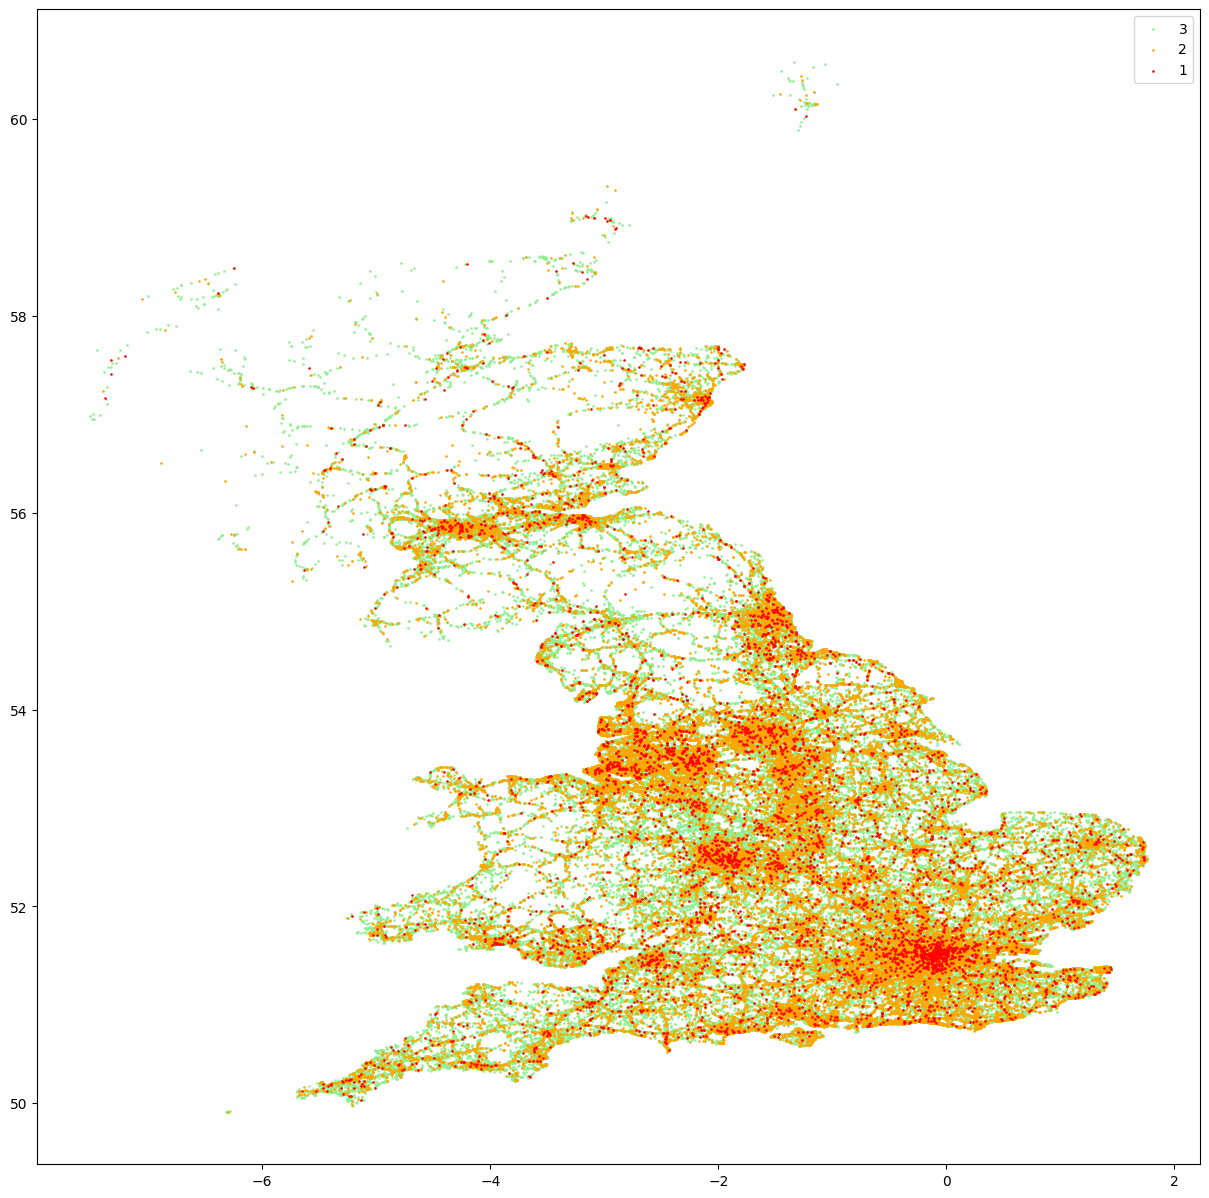

In [12]:
rows = data.groupby('Accident_Severity').agg(
    F.collect_list('Latitude').alias("Latitude"),
    F.collect_list('Longitude').alias("Longitude")).orderBy('Accident_Severity').collect()
legend = [r.Accident_Severity for r in rows]

plt.figure(figsize=(15,15))
colors=['red','orange','lightgreen']
for i in [2,1,0]:
    lat=rows[i].Latitude
    long=rows[i].Longitude
    plt.scatter(long,lat,s=0.7,color=colors[i])
plt.legend([3,2,1])
plt.show()

We can see that accidents are spread across the map and are particularly concentrated in high-density urban areas, especially the high severity ones.

Let's take a look at the distribution of values in the thee different accident severity classes. 

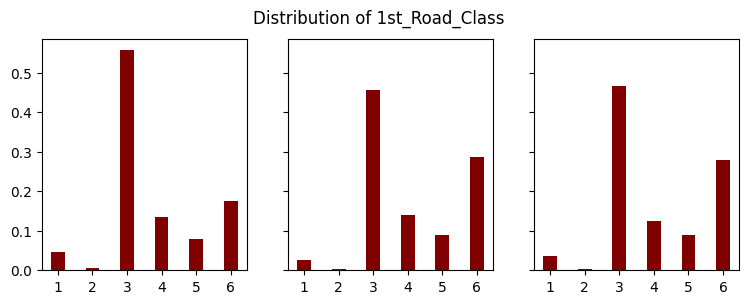

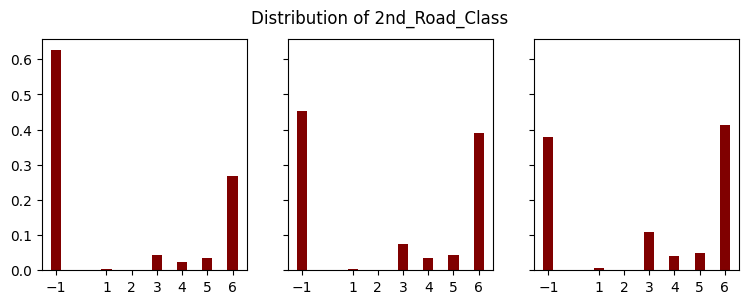

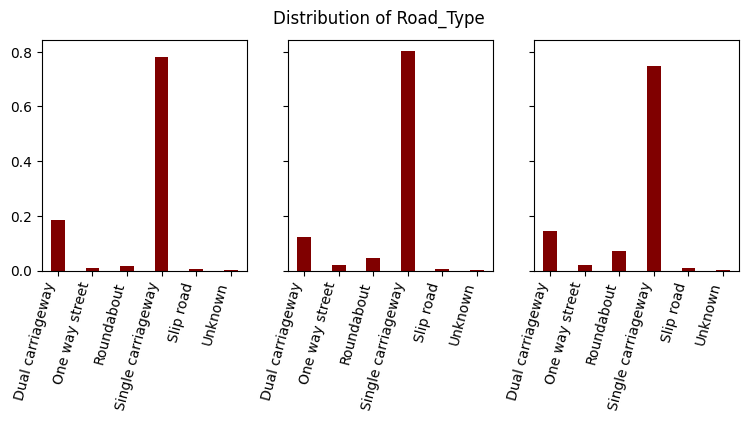

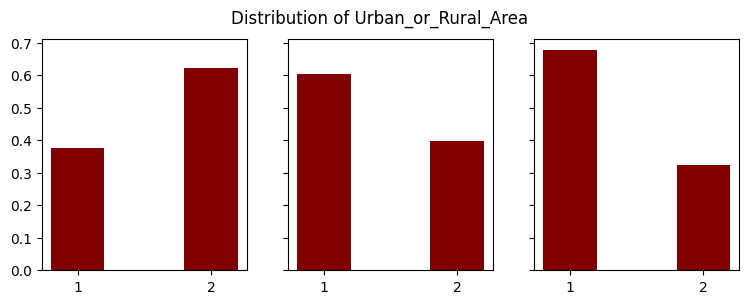

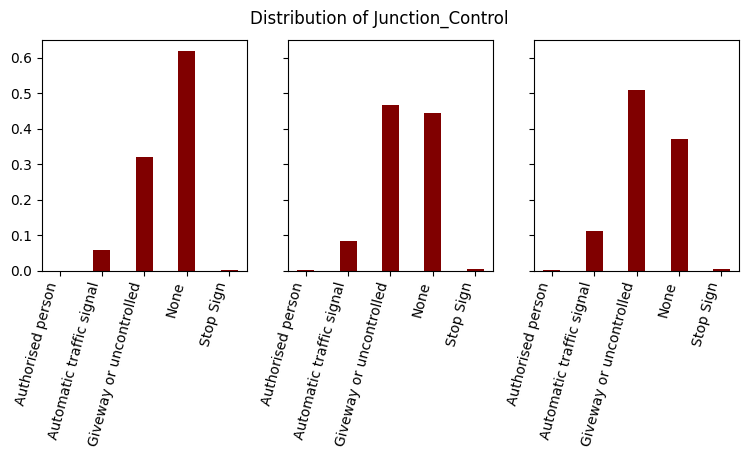

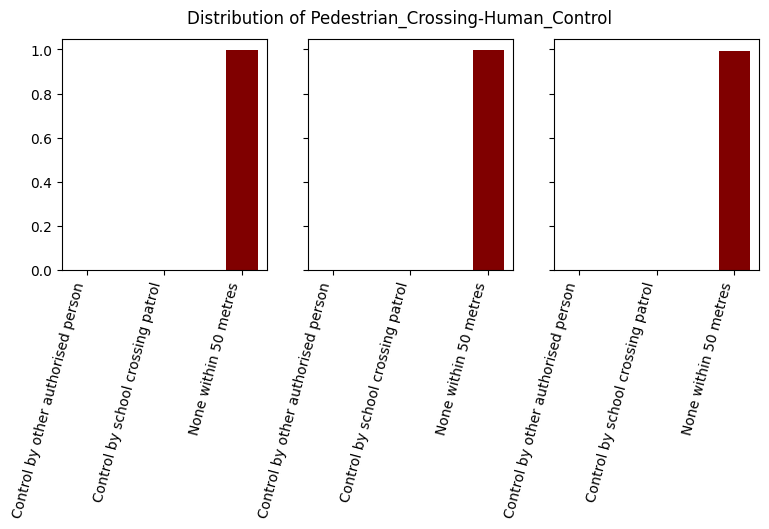

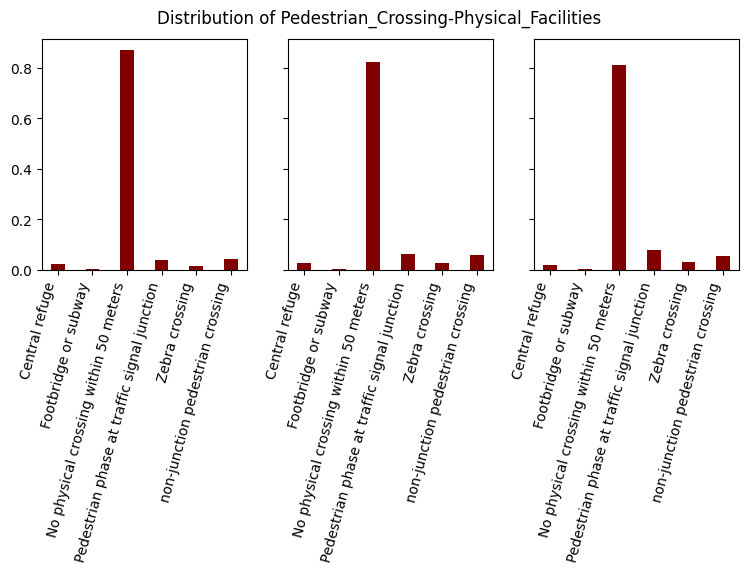

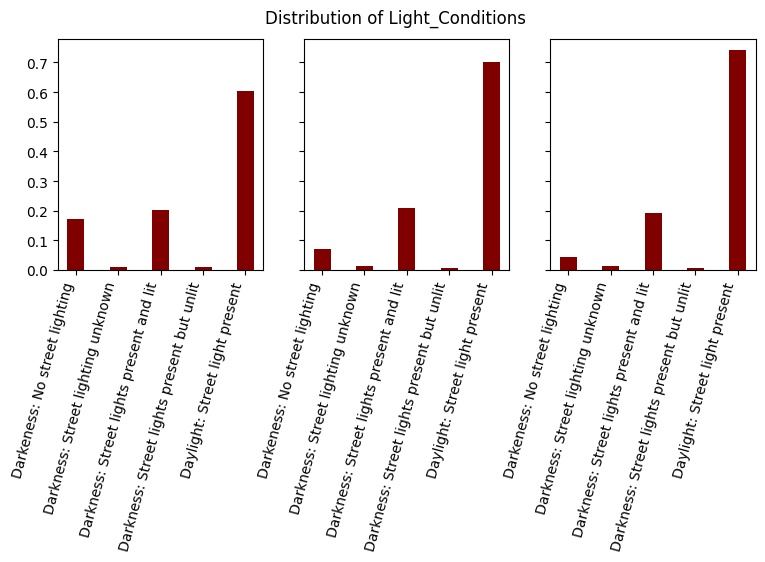

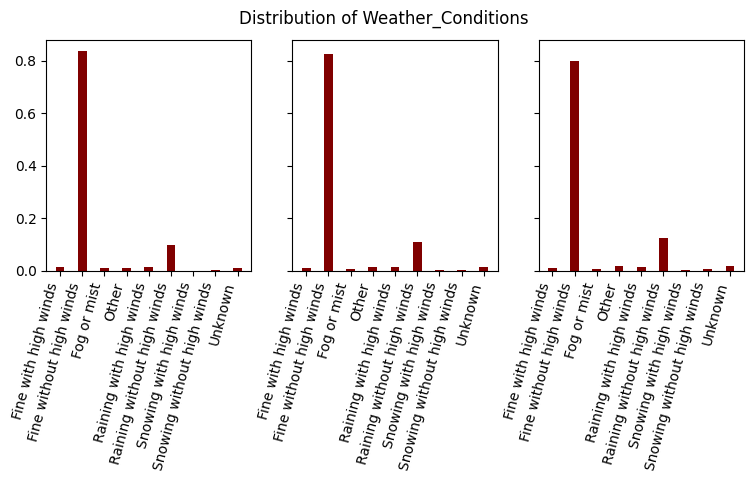

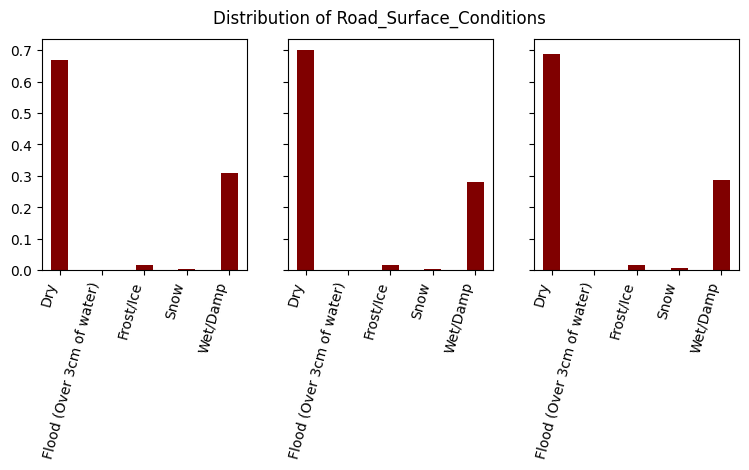

----------------------------------------                                        
Exception occurred during processing of request from ('127.0.0.1', 34790)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
Traceback (most rece

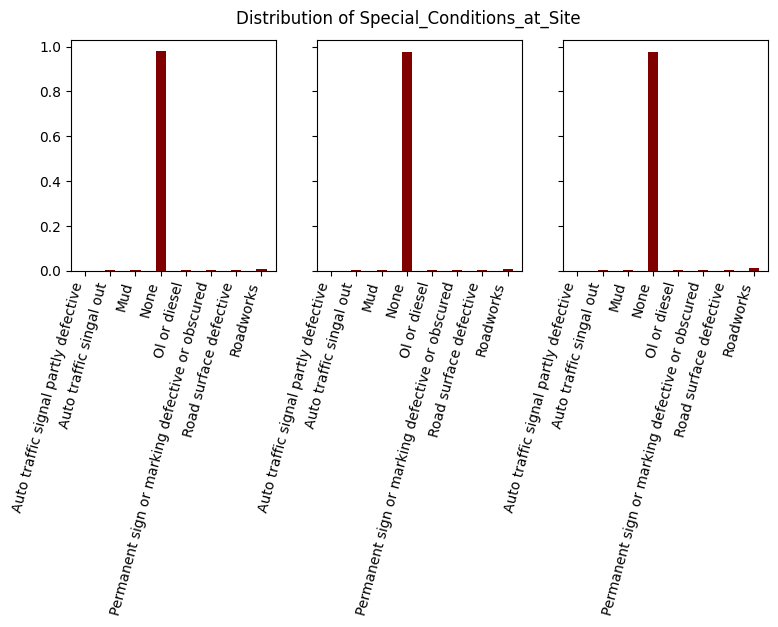

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: functions does not exist in the JVM

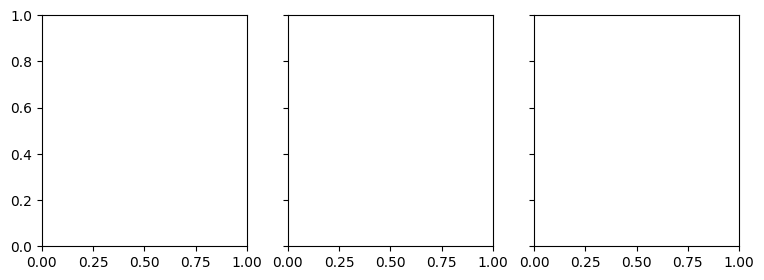

In [19]:
for feature in categorical_features: 
    fig,axs = plt.subplots(1,3,sharey=True)
    fig.set_size_inches(9, 3)
    for i,label in enumerate([1,2,3]):
        values = np.array(data.filter(F.col('Accident_severity')==label).select(feature).rdd.flatMap(lambda x: x).collect())
        distinct_values = np.unique(values)
        n = len(values)
        counts = {val: np.count_nonzero(values == val)/n for val in distinct_values}
        x = list(counts.keys())        
        height = list(counts.values())
        # creating the bar plot
        axs[i].bar(x, height, color ='maroon',
                width = 0.4)
        if isinstance(values[0],str):
            axs[i].set_xticks(axs[i].get_xticks())
            axs[i].set_xticklabels(distinct_values,rotation=75,ha='right')
        else:
            axs[i].set_xticks(distinct_values)
    fig.suptitle(f'Distribution of {feature}')
        
    plt.show()

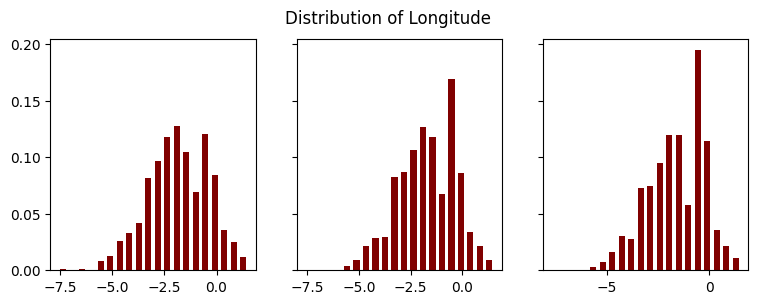

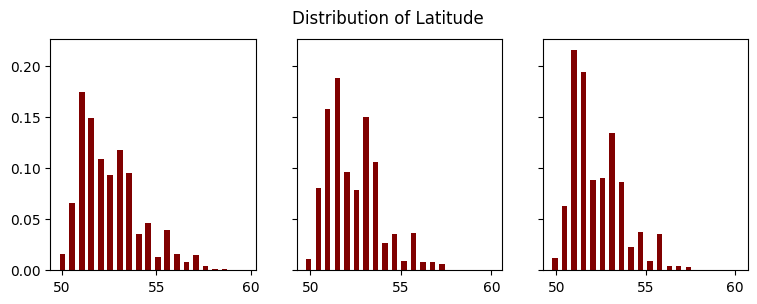

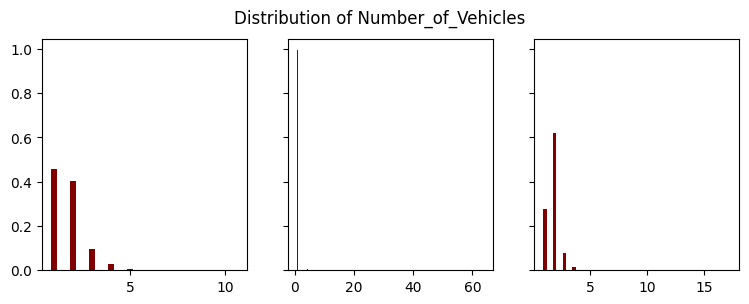

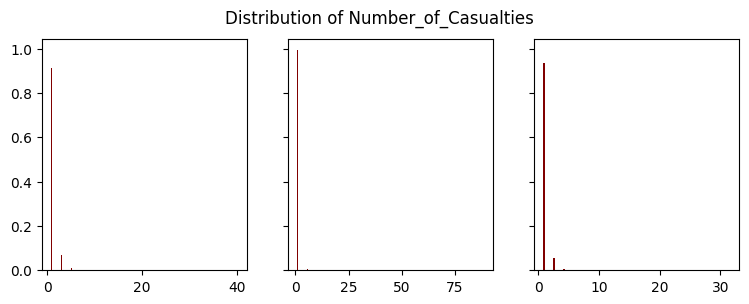

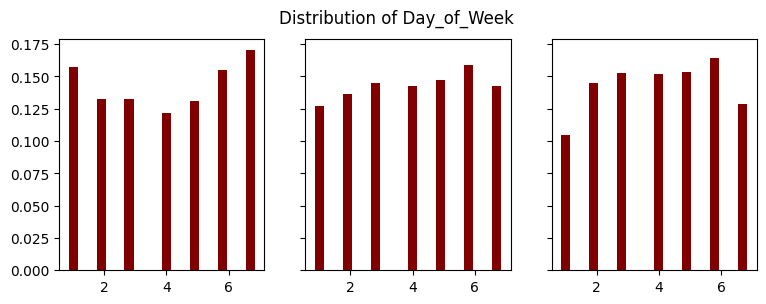

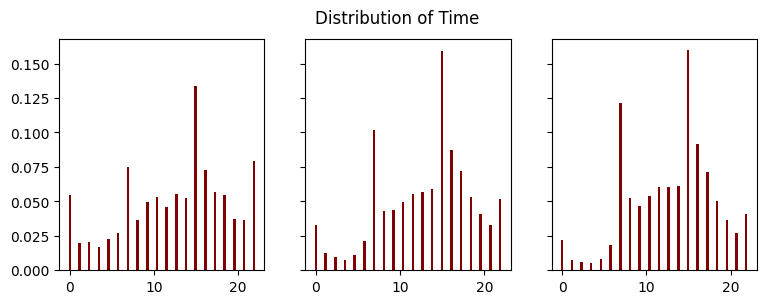

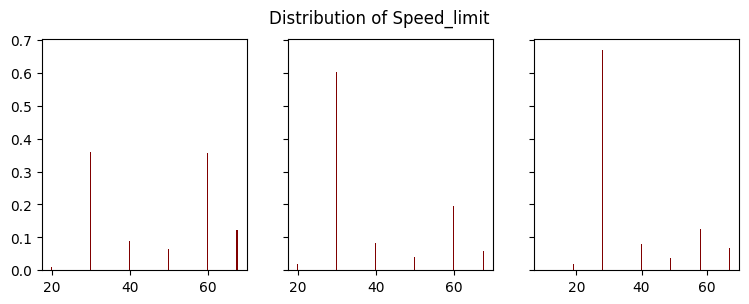

In [33]:
for feature in other_features: 

    fig,axs = plt.subplots(1,3,sharey=True)
    fig.set_size_inches(9, 3)
    for i,label in enumerate([1,2,3]):
        values,counts = data.filter(F.col('Accident_severity')==label).select(feature).rdd.flatMap(lambda x: x).histogram(20)
        n = sum(counts)
        counts = [c/n for c in counts] 
        axs[i].bar(values[:-1], counts, color ='maroon',
                width = 0.3)
    fig.suptitle(f'Distribution of {feature}')
    plt.show()

Observing the distribution of some features offers good insights for an analysis on the major accident causes.
For example, we can see that most accidents happen during rush hours and during night, and mostly happen in low speed roads.
however, no clear pattern emerges that can help to distinguish the three severity classes.

## Prepare train and test features

In [ ]:
indexer = StringIndexer(inputCols=categorical_features,outputCols= ['strindexed_'+c for c in categorical_features])
data = indexer.fit(data).transform(data)#.drop(*inputCols)

In [11]:
onehotencoder = OneHotEncoder(inputCols=['strindexed_' + c for c in categorical_features], 
                              outputCols=['onehot_' + c for c in categorical_features])
data = onehotencoder.fit(data).transform(data)#.drop(*inputCols)

In [13]:
assembler = VectorAssembler(inputCols=all_features, outputCol='features')
data = assembler.transform(data)

In [14]:
train, test = data.randomSplit([0.7,0.3], seed=4000)

In [15]:
train=train.select('features','Accident_Severity').withColumnRenamed('Accident_Severity','label')
test=test.select('features','Accident_Severity').withColumnRenamed('Accident_Severity','label')

### Class balancing weights

To compensate for the imbalance in the distribution of the labels we can add a column 'weight', which is used by the trainer to do sample weighting. This is useful to prevent the model to predict the majority class only which, in this case, accounts for a whooping 85 percent of the data.

In [16]:
y_collect = train.select("label").groupBy("label").count().collect()
unique_y = [x["label"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark) # {0.0: 5.0, 1.0: 0.5555555555555556}

{1: 29.169000179500987, 3: 0.3944368793706506, 2: 2.32311167342154}


In [17]:
mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])

train = train.withColumn("weight", mapping_expr.getItem(F.col("label")))

/usr/local/spark-3.3.1-bin-hadoop3/python/pyspark/sql/column.py:419: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


## Utility functions for model evaluation

In [22]:
def computeMetrics(predictions):    
    #important: need to cast to float type, and order by prediction, else it won't work
    preds_and_labels = predictions.select(['prediction','label']).withColumn('label',F.col('label').cast(FloatType())).orderBy('prediction')

    #select only prediction and label columns
    preds_and_labels = preds_and_labels.select(['prediction','label'])

    return MulticlassMetrics(preds_and_labels.rdd.map(tuple))

def confusion_matrix(metrics):
    ax = sns.heatmap(metrics.confusionMatrix().toArray(), annot=True, xticklabels=[1,2,3],yticklabels=[1,2,3],cbar=False,cmap=None)
    ax.set_ylabel('Actual value')
    ax.set_xlabel('Prediction')

def classification_report(metrics):
    print("\t\tprecision\trecall\tf1_score")
    precs = []
    recs = []
    fscores = []
    for node in [1,2,3]:
        precs.append(metrics.precision(float(node)))
        recs.append(metrics.recall(float(node)))
        fscores.append(metrics.fMeasure(float(node)))
        print(f"{node}\t\t{precs[-1]:.3f}\t\t{recs[-1]:.3f}\t{fscores[-1]:.3f}")
    print(f'avg(macro)\t{np.mean(precs):.3f}\t\t{np.mean(recs):.3f}\t{np.mean(fscores):.3f}')
    print(f'avg(weighted)\t{metrics.weightedPrecision:.3f}\t\t{metrics.weightedRecall:.3f}\t{metrics.weightedFMeasure():.3f}')
    print(f'accuracy\t{metrics.accuracy:.3f}')

# DecisionTree

### Without balancing weights

In [43]:
dt = DecisionTreeClassifier(maxDepth=9)

In [44]:
dtModel = dt.fit(train)

In [45]:
predictions = dtModel.transform(test)

In [46]:
metrics = computeMetrics(predictions)

		precision	recall	f1_score
1		0.000		0.000	0.000
2		0.315		0.005	0.011
3		0.844		0.998	0.915
avg(macro)	0.386		0.335	0.308
avg(weighted)	0.757		0.843	0.773
accuracy	0.843


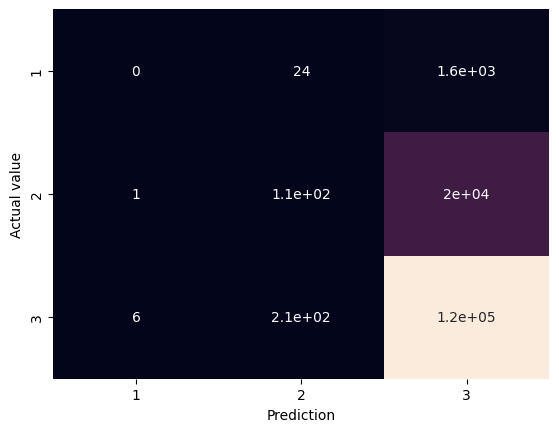

In [47]:
confusion_matrix(metrics)
classification_report(metrics)

### With balancing weights

In [36]:
dt = DecisionTreeClassifier(maxDepth=9,weightCol='weight')

In [39]:
dtModel = dt.fit(train)

In [40]:
predictions = dtModel.transform(test)

In [41]:
metrics = computeMetrics(predictions)

		precision	recall	f1_score
1		0.031		0.617	0.058
2		0.196		0.292	0.235
3		0.898		0.590	0.712
avg(macro)	0.375		0.500	0.335
avg(weighted)	0.787		0.547	0.636
accuracy	0.547


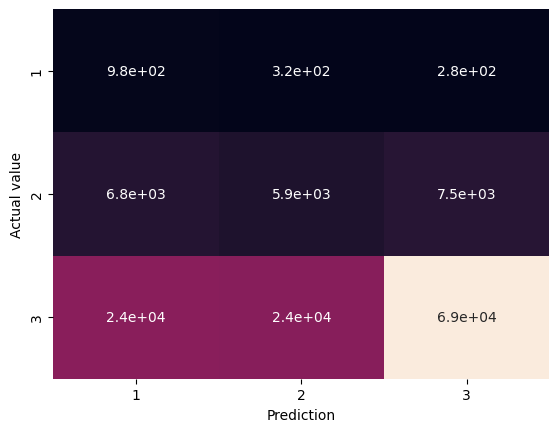

In [42]:
confusion_matrix(metrics)
classification_report(metrics)

### Grid Search and Cross Validation

Using grid search and doing cross validation on the train set would be the best choice in order to obtain the best possible model. Unfortunately, given the large size of the dataset and the limited computational power, this is not a feasible path. 

In [30]:
dt = DecisionTreeClassifier(minInstancesPerNode=12)
grid = ParamGridBuilder()\
        .addGrid(dt.maxDepth, np.arange(5,10))\
        .build()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol='label')
cv = CrossValidator(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator,parallelism=2)
grid,len(grid)

([{Param(parent='DecisionTreeClassifier_a98b771e2abc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5},
  {Param(parent='DecisionTreeClassifier_a98b771e2abc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6},
  {Param(parent='DecisionTreeClassifier_a98b771e2abc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7},
  {Param(parent='DecisionTreeClassifier_a98b771e2abc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 8},
  {Param(parent='DecisionTreeClassifier_a98b771e2abc', name='maxDepth', doc='Maximum depth of the tree. (>= 

In [22]:
#cvModel = cv.fit(train)

----------------------------------------                            (1 + 1) / 2]
Exception occurred during processing of request from ('127.0.0.1', 49166)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
Traceback (most rece

Py4JError: An error occurred while calling o3730.fit

In [ ]:
# predictions = best_model.transform(test)

In [ ]:
# metrics = computeMetrics(predictions)

In [ ]:
# confusion_matrix(metrics)
# classification_report(metrics)

 # Logistic Regression 

### Without balancing weights

In [48]:
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [49]:
lrModel = lr.fit(train)

23/02/13 16:02:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/13 16:02:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [50]:
predictions = lrModel.transform(test)

In [51]:
metrics = computeMetrics(predictions)

		precision	recall	f1_score


1		0.250		0.001	0.003
2		0.500		0.000	0.001
3		0.843		1.000	0.915
avg(macro)	0.531		0.334	0.306
avg(weighted)	0.787		0.843	0.772
accuracy	0.843


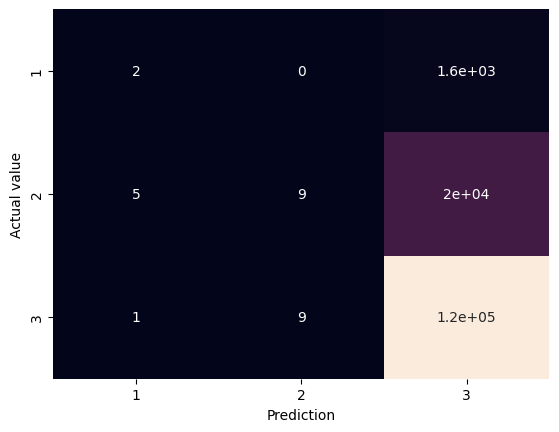

In [52]:
classification_report(metrics)
confusion_matrix(metrics)

### With balancing weights

In [53]:
lr = LogisticRegression(featuresCol="features", labelCol="label", weightCol="weight")

In [54]:
lrModel = lr.fit(train)

In [55]:
predictions = lrModel.transform(test)

In [56]:
metrics = computeMetrics(predictions)

		precision	recall	f1_score


1		0.030		0.620	0.057
2		0.184		0.321	0.234
3		0.899		0.543	0.677
avg(macro)	0.371		0.495	0.323
avg(weighted)	0.785		0.512	0.606
accuracy	0.512


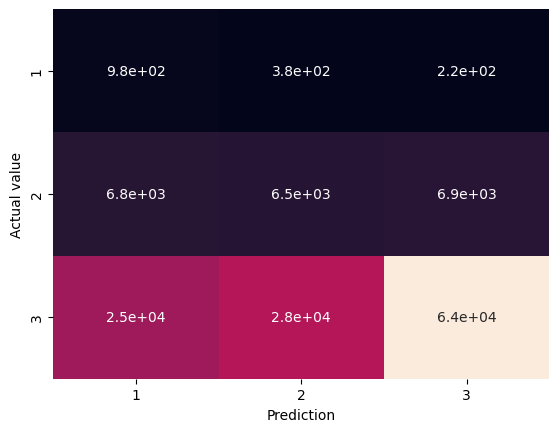

In [57]:
classification_report(metrics)
confusion_matrix(metrics)

# Random Forest

### Wihtout balancing weights

In [59]:
rf = RandomForestClassifier(maxDepth=9)
rfModel = rf.fit(train)

23/02/13 16:58:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.6 KiB


23/02/13 16:58:43 WARN DAGScheduler: Broadcasting large task binary with size 1684.8 KiB


23/02/13 16:59:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.6 KiB


23/02/13 17:00:19 WARN DAGScheduler: Broadcasting large task binary with size 1684.8 KiB


In [60]:
predictions = rfModel.transform(test)

In [61]:
metrics = computeMetrics(predictions)

23/02/13 17:00:43 WARN DAGScheduler: Broadcasting large task binary with size 1024.8 KiB


23/02/13 17:01:25 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB


		precision	recall	f1_score


1		0.000		0.000	0.000
2		0.000		0.000	0.000
3		0.843		1.000	0.915
avg(macro)	0.281		0.333	0.305
avg(weighted)	0.711		0.843	0.772
accuracy	0.843


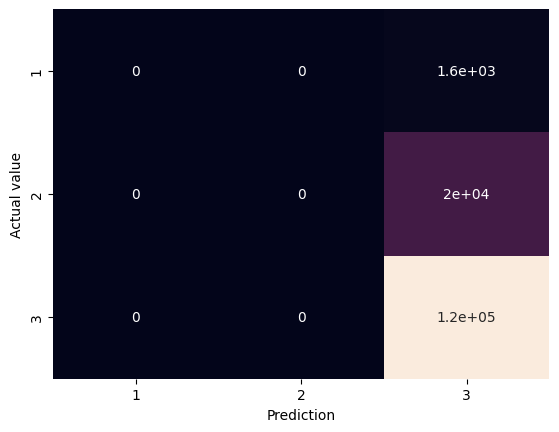

In [62]:
classification_report(metrics)
confusion_matrix(metrics)

### With balancing weigths

In [63]:
rf = RandomForestClassifier(maxDepth=9,weightCol='weight')
rfModel = rf.fit(train)

23/02/13 17:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1110.1 KiB


23/02/13 17:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1768.3 KiB


In [64]:
predictions = rfModel.transform(test)

In [65]:
metrics = computeMetrics(predictions)

23/02/13 17:07:39 WARN DAGScheduler: Broadcasting large task binary with size 1410.0 KiB


23/02/13 17:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1411.3 KiB


23/02/13 17:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1291.1 KiB


		precision	recall	f1_score
23/02/13 17:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1301.8 KiB


1		0.032		0.606	0.061
2		0.215		0.291	0.247
3		0.898		0.625	0.737
avg(macro)	0.382		0.507	0.348
avg(weighted)	0.789		0.576	0.658
accuracy	0.576


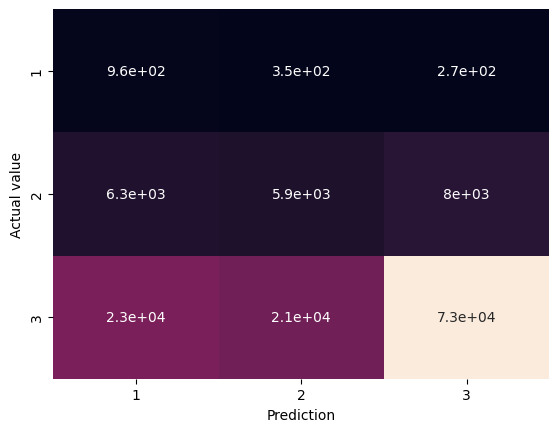

In [66]:
classification_report(metrics)
confusion_matrix(metrics)

## Conclusions

Three different models behave more or less the same way. The best F1 score has been obtained by the random forest which is also the most complex one. Using weight balancing produces a drop in the overall accuracy but helps identifying the least supported classes.

The problem is quite complex, and it's not really clear from the data what is the measure used to evaluate the accident severity. As we have seen in the brief data analysis part, most features have more or less the same distribution in all the classes, maybe we could have discarded some doing feature selection. Also working on data normalization would have been helpful.

The employed models are very simple and were not tuned properly. Some work could also have been done in this direction. 

This said, this work is not aimed to build a reliable model to be used in the real world, this is just a demo tutorial on using Spark and Mllib on a Hadoop cluster to process big data.

Hope you enjoyed! 